# **Smart Queuing**
***Athanasakis Evangelos 2019030118***

***Fragkogiannis Georgios 2019030039***

**Importing Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

**Simulating an M/G/1/FCFS Queuing System**

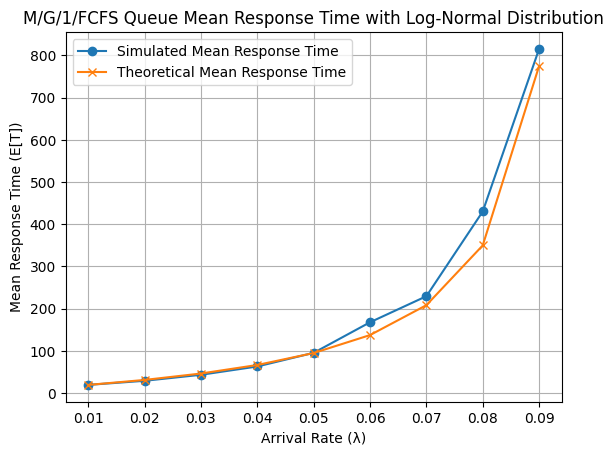

In [2]:
# Define parameters for log-normal distribution
mean_service_time = 10  # seconds
scv = 16                # Squared coefficient of variation
variance_service_time = scv * (mean_service_time ** 2)       # variance = E[s^2] - E[s]^2

E_S_sqrd = variance_service_time + mean_service_time ** 2    # E[s^2] = variance + E[s]^2

# Calculate log-normal parameters mu and sigma
sigma_squared = np.log(variance_service_time / (mean_service_time ** 2) + 1)
mu = np.log(mean_service_time) - sigma_squared / 2
# print(mu)
# print(sigma_squared)

# Generate service times from log-normal distribution
def generate_service_times(n, mu, sigma_squared):
    sigma = np.sqrt(sigma_squared)
    return np.random.lognormal(mu, sigma, n)

# Simulate the M/G/1/FCFS queue
def simulate_MG1_queue(lambda_rate, mu, sigma_squared, num_jobs=1000000):
    inter_arrival_times = np.random.exponential(scale=1/lambda_rate, size=num_jobs) # new job will either start when it arrives in the system, or when the previous job is finished
    arrival_times = np.cumsum(inter_arrival_times)                                  # finish time is the time that the process starts to be processed plus the duration of the processing
    service_times = generate_service_times(num_jobs, mu, sigma_squared)             # total response time is the finish time minus the time of the arrival


    start_times = np.zeros(num_jobs)
    finish_times = np.zeros(num_jobs)
    response_times = np.zeros(num_jobs)

    for i in range(1, num_jobs):
        start_times[i] = max(arrival_times[i], finish_times[i-1])
        finish_times[i] = start_times[i] + service_times[i]
        response_times[i] = finish_times[i] - arrival_times[i]

    return np.mean(response_times)  # Return the mean of the response time E[T]

# Theoretical mean response time
# This function is used to calculate the theoretical responese time (to compare with the simulated one)
def theoretical_mean_response(lambda_rate):
    rho = lambda_rate * mean_service_time
    E_S_sqrd = variance_service_time + mean_service_time ** 2 # In theory, ρ = λ * Ε[S] where E[S] = 10 as defined by the problem
    E_T = mean_service_time + (lambda_rate * E_S_sqrd) / (2 * (1 - rho)) # Ε[Τ] = E[s] + λE[s^2]/(2(1-ρ))
                                                                         # This formula accounts for both the average service time
                                                                         # and the variability in service time (variance).
    return E_T

# Define range of lambda values
# we know from theory that λ = ρ / Ε[s]
rho = np.arange(0.1, 1.0, 0.1)
lambda_vals = rho / mean_service_time

# Initialize lists to store results
simulated_mean_responses = []
theoretical_mean_responses = []

# Run simulations for each λ value
for lambda_rate in lambda_vals:
    simulated_mean_responses.append(simulate_MG1_queue(lambda_rate, mu, sigma_squared))
    theoretical_mean_responses.append(theoretical_mean_response(lambda_rate))

# Plot results
plt.figure()
plt.plot(lambda_vals, simulated_mean_responses, label='Simulated Mean Response Time', marker='o')
plt.plot(lambda_vals, theoretical_mean_responses, label='Theoretical Mean Response Time', marker='x')
plt.xlabel('Arrival Rate (λ)')
plt.ylabel('Mean Response Time (E[T])')
plt.title('M/G/1/FCFS Queue Mean Response Time with Log-Normal Distribution')
plt.legend()
plt.grid(True)
plt.show()




**Implementing the SITA Policy for the queue described above**

In [3]:
#_____________________________Implementing the SITTA policy____________________________



def simulate_sita_queue(lambda_rate, mu1, mu2, cutoff, num_jobs=1000000):
    inter_arrival_times = np.random.exponential(scale=1/lambda_rate, size=num_jobs)
    arrival_times = np.cumsum(inter_arrival_times)

    # Separate job sizes into small and large based on cutoff
    small_job_indices = []
    large_job_indices = []

    for i in range(num_jobs):
        if np.random.lognormal(mu, np.sqrt(sigma_squared)) <= cutoff:
            small_job_indices.append(i)
        else:
            large_job_indices.append(i)

    # Generate service times for each server with the respective mu
    service_times_1 = generate_service_times(len(small_job_indices), mu1, sigma_squared)
    service_times_2 = generate_service_times(len(large_job_indices), mu2, sigma_squared)

    start_times_1 = np.zeros(len(small_job_indices))
    finish_times_1 = np.zeros(len(small_job_indices))
    response_times_1 = np.zeros(len(small_job_indices))

    start_times_2 = np.zeros(len(large_job_indices))
    finish_times_2 = np.zeros(len(large_job_indices))
    response_times_2 = np.zeros(len(large_job_indices))

    # Process small jobs
    for i in range(1, len(small_job_indices)):
        idx = small_job_indices[i]
        start_times_1[i] = max(arrival_times[idx], finish_times_1[i-1])
        finish_times_1[i] = start_times_1[i] + service_times_1[i]
        response_times_1[i] = finish_times_1[i] - arrival_times[idx]

    # Process large jobs
    for i in range(1, len(large_job_indices)):
        idx = large_job_indices[i]
        start_times_2[i] = max(arrival_times[idx], finish_times_2[i-1])
        finish_times_2[i] = start_times_2[i] + service_times_2[i]
        response_times_2[i] = finish_times_2[i] - arrival_times[idx]

    # Combine response times
    combined_response_times = np.concatenate((response_times_1, response_times_2))
    percentage_of_small = len(small_job_indices)/num_jobs

    return np.mean(combined_response_times),percentage_of_small


# # Theoretical mean response time for SITA
def theoretical_mean_response_sita(lambda_rate, mu1, mu2, prob_small):
    mean_service_time_1 = np.exp(mu1+sigma_squared/2)
    mean_service_time_2 = np.exp(mu2+sigma_squared/2)
    # print("\nS1: ",mean_service_time_1)
    # print("S2: ",mean_service_time_2)

    variance_service_time_1 = scv * (mean_service_time_1 ** 2)
    variance_service_time_2 = scv * (mean_service_time_2 ** 2)

    rho1 = (prob_small)*lambda_rate * mean_service_time_1
    rho2 = (1-prob_small)*lambda_rate * mean_service_time_2

    # print("r1 = ",rho1)
    # print("r2 = ",rho2)

    E_S1_sqrd = variance_service_time_1 + mean_service_time_1 ** 2
    E_S2_sqrd = variance_service_time_2 + mean_service_time_2 ** 2

    E_T1 = mean_service_time_1 + ((prob_small)*lambda_rate * E_S1_sqrd) / (2 * (1 - rho1))
    E_T2 = mean_service_time_2 + ((1-prob_small)*lambda_rate * E_S2_sqrd) / (2 * (1 - rho2))

    return E_T1, E_T2

# function to return the optimal values for the cutOff and the ratio of mu1, mu2
def optimise_environment(lambda_rate):
    min_mean_resp_time = np.inf
    optimal_cutoff = 0
    optimal_ratio = 0
    for ratio in np.arange(0.1, 0.6, 0.2): # try all the posibble combinations for mu1, mu2 ratio
        for  cutoff in np.arange(5,50,5):
            mu1 = mu * ratio
            mu2 = mu - mu1

            _,prob_small = simulate_sita_queue(lambda_rate, mu1, mu2, cutoff)
            # simulated_mean_responses_sita.append(mean_to_append)
            #print("prob: ",prob_small)

            E_T1, E_T2 = theoretical_mean_response_sita(lambda_rate, mu1, mu2,prob_small)
            if min_mean_resp_time > ((prob_small)*E_T1 + (1-prob_small)*E_T2):
                min_mean_resp_time = ((prob_small)*E_T1 + (1-prob_small)*E_T2)
                optimal_cutoff = cutoff
                optimal_ratio = ratio


    return optimal_ratio, optimal_cutoff


# Optimal values for rho = 0.5  -> λ = 0.05
ratio1, cutoff1 = optimise_environment(0.05)
# Optimal values for rho = 0.9  -> λ = 0.09
ratio2, cutoff2 = optimise_environment(0.09)

print(f"For rho = 0.5 the optimal parameters are -> Ratio1 = {ratio1}, CutOff1 = {cutoff1}")
print(f"For rho = 0.9 the optimal parameters are -> Ratio2 = {ratio2}, CutOff2 = {cutoff2}")


For rho = 0.5 the optimal parameters are -> Ratio1 = 0.1, CutOff1 = 10
For rho = 0.9 the optimal parameters are -> Ratio2 = 0.1, CutOff2 = 10


**Plotting the mean response time for the optimised system**

prob:  0.799634
prob:  0.799325
prob:  0.800341
prob:  0.800335
prob:  0.799871
prob:  0.800364
prob:  0.800215
prob:  0.799916
prob:  0.800457


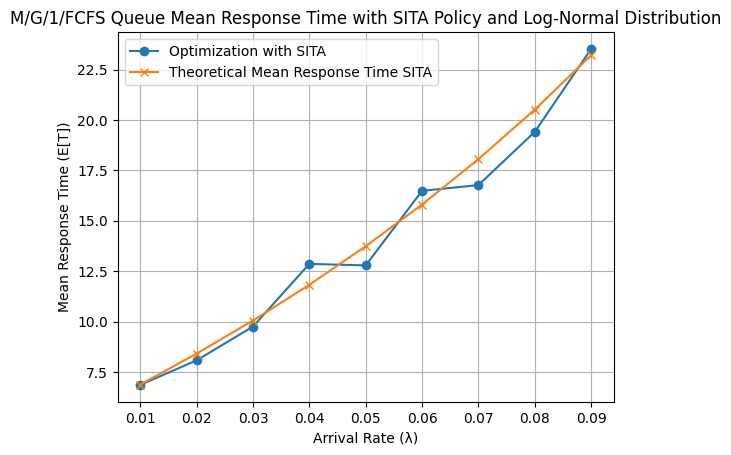

In [4]:
# using the optimal parameters for ρ = 0.5
mu1 = mu * ratio1
mu2 = mu - mu1


# Initialize lists to store results
simulated_mean_responses_sita = []
theoretical_mean_responses_sita = []

# Run simulations for each λ value
for lambda_rate in lambda_vals:
    mean_to_append,prob_small = simulate_sita_queue(lambda_rate, mu1, mu2, cutoff1)
    simulated_mean_responses_sita.append(mean_to_append)
    print("prob: ",prob_small)

    E_T1, E_T2 = theoretical_mean_response_sita(lambda_rate, mu1, mu2,prob_small)
    theoretical_mean_responses_sita.append((prob_small)*E_T1 + (1-prob_small)*E_T2)

# Plot results
plt.figure()
plt.plot(lambda_vals, simulated_mean_responses_sita, label='Optimization with SITA', marker='o')
plt.plot(lambda_vals, theoretical_mean_responses_sita, label='Theoretical Mean Response Time SITA', marker='x')
plt.xlabel('Arrival Rate (λ)')
plt.ylabel('Mean Response Time (E[T])')
plt.title('M/G/1/FCFS Queue Mean Response Time with SITA Policy and Log-Normal Distribution')
plt.legend()
plt.grid(True)
plt.show()
